In [1]:
%load_ext autoreload
%autoreload 2

#pyplot
import matplotlib.pyplot as plt

# model
import torch
import torch_geometric


from auxiliary.config import get_config, ModelType, NetworkType
from training.models import GCN, FCNN
from training.dataloader import DataLoader
from training.training import Run, evaluate_dataset, process_datapoint
import training.evaluation as metrics
from training.postprocessing import ActSpaceCache

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/grid2op/Backend/PandaPowerBackend.py:30: UserWarning: Numba cannot be loaded. You will gain possibly massive speed if installing it by 
	/Library/Frameworks/Python.framework/Versions/3.12/bin/python3.12 -m pip install numba

  warnings.warn("Numba cannot be loaded. You will gain possibly massive speed if installing it by "


In [2]:
config = get_config()
train_config = config['training']

In [3]:
train_config

{'settings': {'train_log_freq': 2000,
  'val_log_freq': 5000,
  'dp_per_val_log': 25000,
  'advanced_val_analysis': True,
  'line_outages_considered': [-1, 0, 1, 2, 3, 4, 5, 6, 12]},
 'hyperparams': {'model_type': <ModelType.FCNN: 'FCNN'>,
  'n_epoch': 100,
  'lr': 0.0005,
  'N_node_hidden': 230,
  'LReLu_neg_slope': 0.1,
  'batch_size': 64,
  'label_smoothing_alpha': 0,
  'weight_init_std': 3,
  'weight_decay': 0,
  'early_stopping_patience': 50,
  'very_early_filter_step': 300000,
  'very_early_filter_threshold': 0.4,
  'label_weights': {'type': <LabelWeightsType.Y_AND_P: 'Y_AND_P'>,
   'non_masked_weight': 0.1}},
 'constants': {'estimated_train_size': 36497},
 'GCN': {'hyperparams': {'network_type': <NetworkType.HETERO: 'heterogeneous'>,
   'N_GCN_layers': 8,
   'aggr': <AggrType.ADD: 'add'>,
   'layer_type': <LayerType.SAGECONV: 'SAGEConv'>,
   'GINConv_nn_depth': 2},
  'constants': {'N_f_gen': 3, 'N_f_load': 3, 'N_f_endpoint': 6}},
 'FCNN': {'hyperparams': {'N_layers': 5},
  'cons

# Loading model
Note: config must contain the hyperparameters used by the model

In [11]:
model_type = config['training']['hyperparams']['model_type']

if model_type == ModelType.GCN:
    model = GCN(train_config['hyperparams']['LReLu_neg_slope'],
                train_config['hyperparams']['weight_init_std'],
                train_config['GCN']['constants']['N_f_gen'],
                train_config['GCN']['constants']['N_f_load'],
                train_config['GCN']['constants']['N_f_endpoint'],
                train_config['GCN']['hyperparams']['N_GCN_layers'],
                train_config['hyperparams']['N_node_hidden'],
                train_config['GCN']['hyperparams']['aggr'],
                train_config['GCN']['hyperparams']['network_type'],
                train_config['GCN']['hyperparams']['layer_type'],
                train_config['GCN']['hyperparams']['GINConv_nn_depth'])
elif model_type == ModelType.FCNN:
    model = FCNN(train_config['hyperparams']['LReLu_neg_slope'],
                 train_config['hyperparams']['weight_init_std'],
                 train_config['FCNN']['constants']['size_in'],
                 train_config['FCNN']['constants']['size_out'],
                 train_config['FCNN']['hyperparams']['N_layers'],
                 train_config['hyperparams']['N_node_hidden'])

In [12]:
model_path = config['paths']['model']
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)

<All keys matched successfully>

# Analysing seen data

In [8]:
seen_processed_data_path = config['paths']['data']['processed']
seen_matrix_cache_path = seen_processed_data_path + 'auxiliary_data_objects/con_matrix_cache.json'

unseen_processed_data_path = 'data/processed/greedy_unseen/'
unseen_matrix_cache_path = unseen_processed_data_path + 'auxiliary_data_objects/con_matrix_cache.json'

feature_statistics_path = seen_processed_data_path + 'auxiliary_data_objects/feature_stats.json'
model_type = config['training']['hyperparams']['model_type']
network_type = train_config['GCN']['hyperparams']['network_type']

dataloaders = {'seen': {}, 'unseen': {}}
for data, processed_data_path, matrix_cache_path in [('seen', seen_processed_data_path, seen_matrix_cache_path)]:#: , #('unseen', unseen_processed_data_path, unseen_matrix_cache_path)):
    for partition in ('train', 'val', 'test'):
        dataloaders[data][partition] = DataLoader(processed_data_path + '/' + partition, matrix_cache_path, feature_statistics_path, 'cpu',  model_type, network_type)

In [ ]:
%%capture

# Initialize metrics objects
IA = metrics.IncrementalAverage
metrics_dict = {
    'macro_accuracy': (metrics.macro_accuracy, IA()),
    'micro_accuracy': (metrics.micro_accuracy, IA()),
    'n_predicted_changes': (metrics.n_predicted_changes, IA()),
    'any_predicted_changes': (metrics.any_predicted_changes, IA()),
    'macro_accuracy_one_sub': (metrics.macro_accuracy_one_sub, IA()),
    'micro_accuracy_one_sub': (metrics.micro_accuracy_one_sub, IA()),
    'train_loss': (lambda **kwargs: kwargs['l'], IA()),
    'accuracy_predicted_substation':
        (metrics.accuracy_predicted_substation, IA())
}
val_metrics_dict = dict([('val_' + k, v) for k, v in metrics_dict.items()])
val_metrics_dict['val_macro_accuracy_valid'] = (metrics.macro_accuracy_valid, IA())
val_metrics_dict['val_micro_accuracy_valid'] = (metrics.micro_accuracy_valid, IA())
IAM = metrics.IncrementalAverageMetrics
eval_metrics = IAM(val_metrics_dict)

# Initialize action space cache used for
as_cache = ActSpaceCache(line_outages_considered=train_config['settings']['line_outages_considered'])

# Analyzing seen topologies

In [ ]:
%%capture
%tb
plt.ioff()
results = {}

for partition, dataloader in dataloaders['seen'].items():
        
    eval_metrics.reset()
    _ = evaluate_dataset(model, dataloader, as_cache, eval_metrics)

    results[partition] = {
        'val_macro_accuracy_valid':  eval_metrics.metrics_dict['val_macro_accuracy_valid'][1].get(),
        'loss':  eval_metrics.metrics_dict['val_train_loss'][1].get()
    }


In [ ]:
results

# Analyzing unseen topologies

In [15]:
%%capture
for data, processed_data_path, matrix_cache_path in [('unseen', unseen_processed_data_path, unseen_matrix_cache_path)]:
    for partition in ('train', 'val', 'test'):
        dataloaders[data][partition] = DataLoader(processed_data_path + '/' + partition, matrix_cache_path, feature_statistics_path, 'cpu',  model_type, network_type)

# Initialize metrics objects
IA = metrics.IncrementalAverage
metrics_dict = {
    'macro_accuracy': (metrics.macro_accuracy, IA()),
    'micro_accuracy': (metrics.micro_accuracy, IA()),
    'n_predicted_changes': (metrics.n_predicted_changes, IA()),
    'any_predicted_changes': (metrics.any_predicted_changes, IA()),
    'macro_accuracy_one_sub': (metrics.macro_accuracy_one_sub, IA()),
    'micro_accuracy_one_sub': (metrics.micro_accuracy_one_sub, IA()),
    'train_loss': (lambda **kwargs: kwargs['l'], IA()),
    'accuracy_predicted_substation':
        (metrics.accuracy_predicted_substation, IA())
}
val_metrics_dict = dict([('val_' + k, v) for k, v in metrics_dict.items()])
val_metrics_dict['val_macro_accuracy_valid'] = (metrics.macro_accuracy_valid, IA())
val_metrics_dict['val_micro_accuracy_valid'] = (metrics.micro_accuracy_valid, IA())
IAM = metrics.IncrementalAverageMetrics
eval_metrics = IAM(val_metrics_dict)

# Initialize action space cache used for
as_cache = ActSpaceCache(line_outages_considered=train_config['settings']['line_outages_considered'])
#_ = evaluate_dataset(model, dataloader, as_cache, eval_metrics)

In [16]:
%%capture
%tb
plt.ioff()
results = {}

for partition, dataloader in dataloaders['unseen'].items():
        
    eval_metrics.reset()
    figures = evaluate_dataset(model, dataloader, as_cache, eval_metrics)

    results[partition] = {
        'val_macro_accuracy_valid':  eval_metrics.metrics_dict['val_macro_accuracy_valid'][1].get(),
        'loss':  eval_metrics.metrics_dict['val_train_loss'][1].get()
    }


NameError: name 'model' is not defined

In [17]:
results

{'train': {'val_macro_accuracy_valid': 0.34170633174673015,
  'loss': tensor(0.2687)},
 'val': {'val_macro_accuracy_valid': 0.3724077328646749,
  'loss': tensor(0.2623)},
 'test': {'val_macro_accuracy_valid': 0.3449386985224772,
  'loss': tensor(0.2617)}}

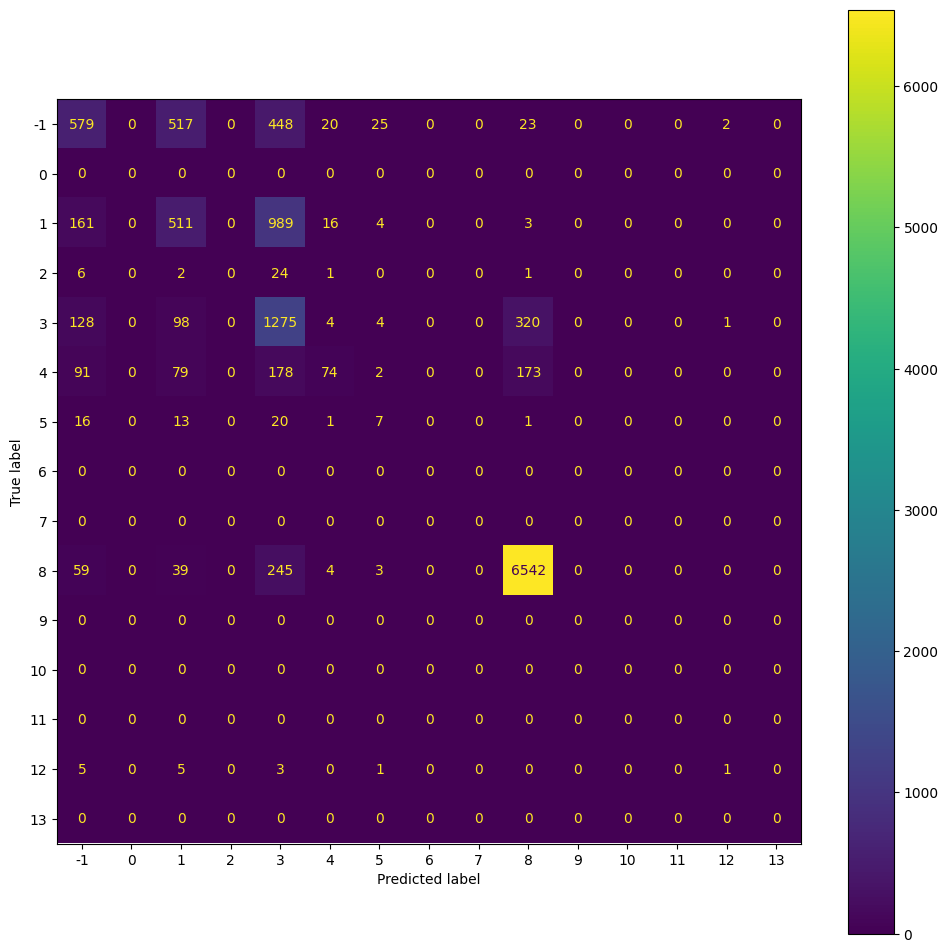

In [18]:
figures['substation_confusion_matrix']

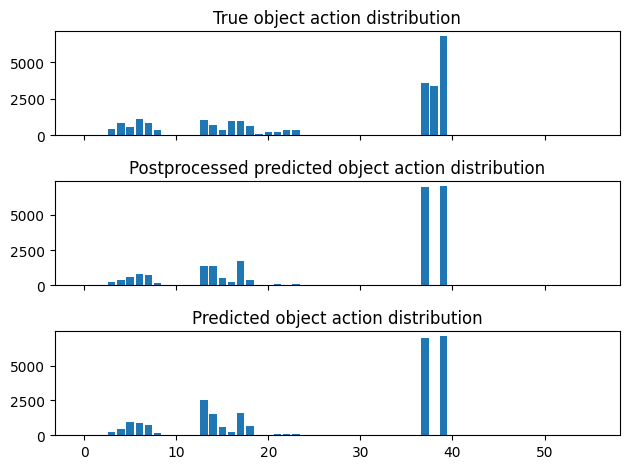

In [19]:
figures['affected_objects']

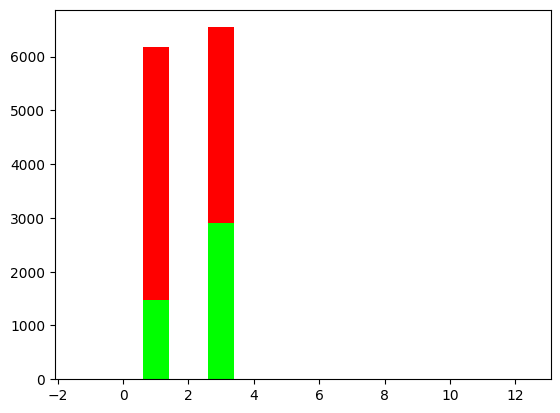

In [20]:
figures['accuracy_per_lineout']

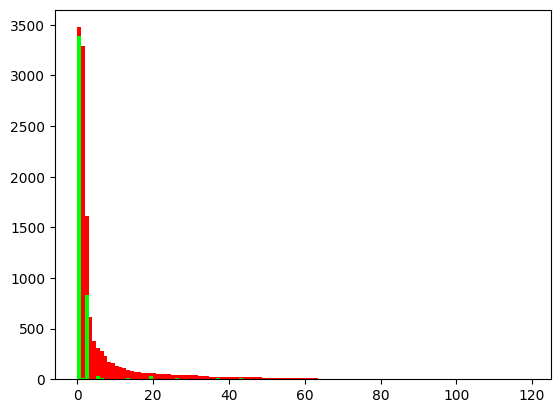

In [21]:
figures['accuracy_per_label']

# Computing results for multiple models

In [ ]:
import numpy as np
import tqdm

model_numbers = np.arange(1,6)
results = {}

# Data
seen_processed_data_path = config['paths']['data']['processed']
seen_matrix_cache_path = seen_processed_data_path + 'auxiliary_data_objects/con_matrix_cache.json'
feature_statistics_path = seen_processed_data_path + 'auxiliary_data_objects/feature_stats.json'
model_type = config['training']['hyperparams']['model_type']
network_type = train_config['GCN']['hyperparams']['network_type']

# Metrics
# Initialize metrics objects
IA = metrics.IncrementalAverage
metrics_dict = {
    'macro_accuracy': (metrics.macro_accuracy, IA()),
    'micro_accuracy': (metrics.micro_accuracy, IA()),
    'n_predicted_changes': (metrics.n_predicted_changes, IA()),
    'any_predicted_changes': (metrics.any_predicted_changes, IA()),
    'macro_accuracy_one_sub': (metrics.macro_accuracy_one_sub, IA()),
    'micro_accuracy_one_sub': (metrics.micro_accuracy_one_sub, IA()),
    'train_loss': (lambda **kwargs: kwargs['l'], IA()),
    'accuracy_predicted_substation':
        (metrics.accuracy_predicted_substation, IA())
}
val_metrics_dict = dict([('val_' + k, v) for k, v in metrics_dict.items()])
val_metrics_dict['val_macro_accuracy_valid'] = (metrics.macro_accuracy_valid, IA())
val_metrics_dict['val_micro_accuracy_valid'] = (metrics.micro_accuracy_valid, IA())
IAM = metrics.IncrementalAverageMetrics
eval_metrics = IAM(val_metrics_dict)

# Action space cache
as_cache = ActSpaceCache(line_outages_considered=train_config['settings']['line_outages_considered'])

for i in tqdm.tqdm(model_numbers):
    
    # Model
    model = GCN(train_config['hyperparams']['LReLu_neg_slope'],
                train_config['hyperparams']['weight_init_std'],
                train_config['GCN']['constants']['N_f_gen'],
                train_config['GCN']['constants']['N_f_load'],
                train_config['GCN']['constants']['N_f_endpoint'],
                train_config['GCN']['hyperparams']['N_GCN_layers'],
                train_config['hyperparams']['N_node_hidden'],
                train_config['GCN']['hyperparams']['aggr'],
                train_config['GCN']['hyperparams']['network_type'],
                train_config['GCN']['hyperparams']['layer_type'],
                train_config['GCN']['hyperparams']['GINConv_nn_depth'])

    model_path = f'models/Hetero_unseen_{i}'
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)

    # Dataloader
    dataloader = DataLoader(seen_processed_data_path + '/test', seen_matrix_cache_path, feature_statistics_path, 'cpu',  model_type, network_type)

    # Evaluate
    eval_metrics.reset()
    figures = evaluate_dataset(model, dataloader, as_cache, eval_metrics)

    results[i] = {
        'val_macro_accuracy_valid':  eval_metrics.metrics_dict['val_macro_accuracy_valid'][1].get(),
        'loss':  eval_metrics.metrics_dict['val_train_loss'][1].get()
    }

In [ ]:
results

In [ ]:
mean_accuracy = np.mean([v['val_macro_accuracy_valid'] for v in results.values()])
std_accuracy = np.std([v['val_macro_accuracy_valid'] for v in results.values()])
print(mean_accuracy)
print(std_accuracy)

In [ ]:
import numpy as np
import tqdm

model_numbers = np.arange(1,6)
results = {}

# Data
unseen_processed_data_path = 'data/processed/greedy_unseen/'
unseen_matrix_cache_path = unseen_processed_data_path + 'auxiliary_data_objects/con_matrix_cache.json'

feature_statistics_path = seen_processed_data_path + 'auxiliary_data_objects/feature_stats.json'
model_type = config['training']['hyperparams']['model_type']
network_type = train_config['GCN']['hyperparams']['network_type']

# Metrics
# Initialize metrics objects
IA = metrics.IncrementalAverage
metrics_dict = {
    'macro_accuracy': (metrics.macro_accuracy, IA()),
    'micro_accuracy': (metrics.micro_accuracy, IA()),
    'n_predicted_changes': (metrics.n_predicted_changes, IA()),
    'any_predicted_changes': (metrics.any_predicted_changes, IA()),
    'macro_accuracy_one_sub': (metrics.macro_accuracy_one_sub, IA()),
    'micro_accuracy_one_sub': (metrics.micro_accuracy_one_sub, IA()),
    'train_loss': (lambda **kwargs: kwargs['l'], IA()),
    'accuracy_predicted_substation':
        (metrics.accuracy_predicted_substation, IA())
}
val_metrics_dict = dict([('val_' + k, v) for k, v in metrics_dict.items()])
val_metrics_dict['val_macro_accuracy_valid'] = (metrics.macro_accuracy_valid, IA())
val_metrics_dict['val_micro_accuracy_valid'] = (metrics.micro_accuracy_valid, IA())
IAM = metrics.IncrementalAverageMetrics
eval_metrics = IAM(val_metrics_dict)

# Action space cache
as_cache = ActSpaceCache(line_outages_considered=train_config['settings']['line_outages_considered'])

for i in tqdm.tqdm(model_numbers):
    
  # Model
    model = GCN(train_config['hyperparams']['LReLu_neg_slope'],
                train_config['hyperparams']['weight_init_std'],
                train_config['GCN']['constants']['N_f_gen'],
                train_config['GCN']['constants']['N_f_load'],
                train_config['GCN']['constants']['N_f_endpoint'],
                train_config['GCN']['hyperparams']['N_GCN_layers'],
                train_config['hyperparams']['N_node_hidden'],
                train_config['GCN']['hyperparams']['aggr'],
                train_config['GCN']['hyperparams']['network_type'],
                train_config['GCN']['hyperparams']['layer_type'],
                train_config['GCN']['hyperparams']['GINConv_nn_depth'])

    model_path = f'models/Hetero_unseen_{i}'
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)


    # Dataloader
    dataloader = DataLoader(unseen_processed_data_path + '/test', unseen_matrix_cache_path, feature_statistics_path, 'cpu',  model_type, network_type)

    # Evaluate
    eval_metrics.reset()
    figures = evaluate_dataset(model, dataloader, as_cache, eval_metrics)

    results[i] = {
        'val_macro_accuracy_valid':  eval_metrics.metrics_dict['val_macro_accuracy_valid'][1].get(),
        'loss':  eval_metrics.metrics_dict['val_train_loss'][1].get()
    }

In [ ]:
results

In [ ]:
mean_accuracy = np.mean([v['val_macro_accuracy_valid'] for v in results.values()])
std_accuracy = np.std([v['val_macro_accuracy_valid'] for v in results.values()])
print(mean_accuracy)
print(std_accuracy)

## Boxplots

Text(0.5, 1.0, 'Accuracies on the Test Set of Seen Networks')

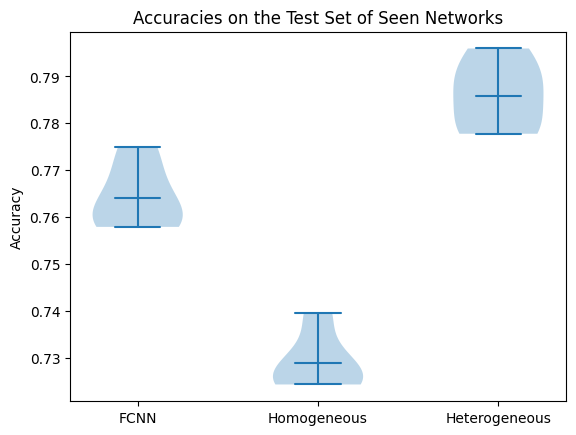

In [48]:
import matplotlib.pyplot as plt
import numpy as np

seen_fcnn_accs = [0.7748490060397584, 0.7578896844126235, 0.7677292908283668, 0.7593296268149274, 0.7609695612175513]
#unseen_fcnn_accs = [0.3449386985224772, 0.3489468720528136, 0.34855391386356493,0.3362150267211569, 0.35853505187048096]
seen_homo_accs = [0.7254509819607216, 0.7299708011679533, 0.7242510299588016, 0.7251709931602736,0.7394504219831207]
seen_hetero_accs = [0.7959681612735491, 0.7900483980640775, 0.7868085276588936, 0.7786488540458382, 0.7777688892444302]

plt.violinplot([seen_fcnn_accs, seen_homo_accs, seen_hetero_accs],
              showmeans=True)
plt.gca().set_xticks([1, 2, 3])
plt.gca().set_xticklabels(['FCNN', 'Homogeneous', 'Heterogeneous'])
plt.ylabel('Accuracy')
plt.title('Accuracies on the Test Set of Seen Networks')
           #labels=≈)

Text(0.5, 1.0, 'Accuracies on the Test Set of Unseen Networks')

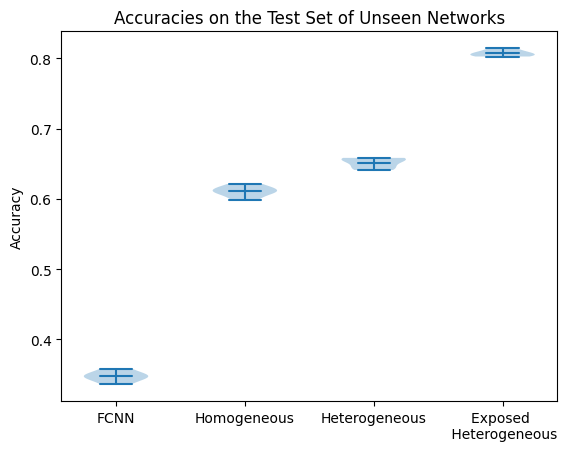

In [49]:
unseen_fcnn_accs = [0.3449386985224772, 0.3489468720528136, 0.34855391386356493, 0.3362150267211569, 0.35853505187048096]
unseen_homo_accs = [0.6087708267840302, 0.6119930839358693, 0.5985539138635649, 0.6211097139264382, 0.6128575919522162]
unseen_hetero_accs = [0.655297076391072, 0.6583621502672116, 0.657340458975165, 0.6452373467463062, 0.6411505815781201]
exposed_hetero_accs = [0.8025778057214712, 0.8088651367494498, 0.8142879597610814, 0.8068217541653568, 0.803520905375668]

plt.violinplot([unseen_fcnn_accs, unseen_homo_accs, unseen_hetero_accs, exposed_hetero_accs],
              showmeans=True)
plt.gca().set_xticks([1, 2, 3, 4])
plt.gca().set_xticklabels(['FCNN', 'Homogeneous', 'Heterogeneous', 'Exposed \n Heterogeneous'])
plt.ylabel('Accuracy')
plt.title('Accuracies on the Test Set of Unseen Networks')

# Error Analysis

In [50]:
processed_data_path = config['paths']['data']['processed']
matrix_cache_path = processed_data_path + 'auxiliary_data_objects/con_matrix_cache.json'

feature_statistics_path = processed_data_path + 'auxiliary_data_objects/feature_stats.json'
model_type = config['training']['hyperparams']['model_type']
network_type = train_config['GCN']['hyperparams']['network_type']

In [51]:
model = FCNN(train_config['hyperparams']['LReLu_neg_slope'],
                 train_config['hyperparams']['weight_init_std'],
                 train_config['FCNN']['constants']['size_in'],
                 train_config['FCNN']['constants']['size_out'],
                 train_config['FCNN']['hyperparams']['N_layers'],
                 train_config['hyperparams']['N_node_hidden'])

In [52]:
model_path = config['paths']['model']
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)

dataloader = DataLoader(processed_data_path + '/val', matrix_cache_path, feature_statistics_path, 'cpu',  model_type, network_type)

# Metrics
# Initialize metrics objects
IA = metrics.IncrementalAverage
metrics_dict = {
    'macro_accuracy': (metrics.macro_accuracy, IA()),
    'micro_accuracy': (metrics.micro_accuracy, IA()),
    'n_predicted_changes': (metrics.n_predicted_changes, IA()),
    'any_predicted_changes': (metrics.any_predicted_changes, IA()),
    'macro_accuracy_one_sub': (metrics.macro_accuracy_one_sub, IA()),
    'micro_accuracy_one_sub': (metrics.micro_accuracy_one_sub, IA()),
    'train_loss': (lambda **kwargs: kwargs['l'], IA()),
    'accuracy_predicted_substation':
        (metrics.accuracy_predicted_substation, IA())
}
val_metrics_dict = dict([('val_' + k, v) for k, v in metrics_dict.items()])
val_metrics_dict['val_macro_accuracy_valid'] = (metrics.macro_accuracy_valid, IA())
val_metrics_dict['val_micro_accuracy_valid'] = (metrics.micro_accuracy_valid, IA())
IAM = metrics.IncrementalAverageMetrics
eval_metrics = IAM(val_metrics_dict)

# Action space cache
as_cache = ActSpaceCache(line_outages_considered=train_config['settings']['line_outages_considered'])

AttributeError: module 'sklearn.metrics' has no attribute 'IncrementalAverage'

In [53]:
import numpy as np
import tqdm

datapoints = []

for dp in tqdm.tqdm(dataloader):
    l, Y, P, nearest_valid_P, Y_sub_idx, Y_sub_mask, P_subchanged_idx, \
                nearest_valid_actions = process_datapoint(dp, model, as_cache, eval_metrics)

    Y_string = ''.join([str(int(i)) for i in dp['full_change_topo_vect'].tolist()])
    P_string = ''.join([str(int(i)) for i in nearest_valid_P.tolist()])
    
    datapoints.append([dp['features'].numpy(), Y_string, P_string])

16991it [00:16, 1027.92it/s]


KeyboardInterrupt: 

In [12]:
#from sklearn import metrics 

confusion_matrix = metrics.confusion_matrix([dp[1] for dp in datapoints], [dp[2] for dp in datapoints]) 

In [13]:
from collections import Counter

confusions = Counter()

for dp in datapoints:
    Y = dp[1]
    P = dp[2]

    if Y==P:
        continue
        
    if int(Y, 2) < int(P, 2):
        confusions[(Y, P)] += 1
    else:
        confusions[(P, Y)] += 1

In [14]:
most_common_confusions = confusions.most_common()

In [15]:
import numpy as np
from sklearn.decomposition import PCA

#X_size = 4000
X = np.array([dp[0] for dp in datapoints])
pca = PCA(n_components=2)
pca.fit(X)
PCA(n_components=2)

PCA(n_components=2)

In [16]:
confusion_rank = 0
confused_class1, confused_class2 = most_common_confusions[confusion_rank][0]
color_map = {confused_class1: 'g', confused_class2: 'b'}

datapoints_either_class = [dp for dp in datapoints if dp[1] in (confused_class1, confused_class2)]
either_class_color = [color_map[dp[1]] for dp in datapoints_either_class]
either_class_X = np.array([dp[0] for dp in datapoints_either_class])

confused = [dp for dp in datapoints_either_class if (dp[1] != dp[2] and dp[2] in (confused_class1, confused_class2))]
confused_X = np.array([dp[0] for dp in confused])

In [17]:
pca.transform(either_class_X)

array([[-1.890941 , -4.910772 ],
       [-1.5249497, -4.9304013],
       [-1.8609091, -4.975102 ],
       ...,
       [-2.2136629, -2.302388 ],
       [-1.6232439, -2.3282003],
       [-2.0648365, -2.1214323]], dtype=float32)

In [18]:
either_class_Y

NameError: name 'either_class_Y' is not defined

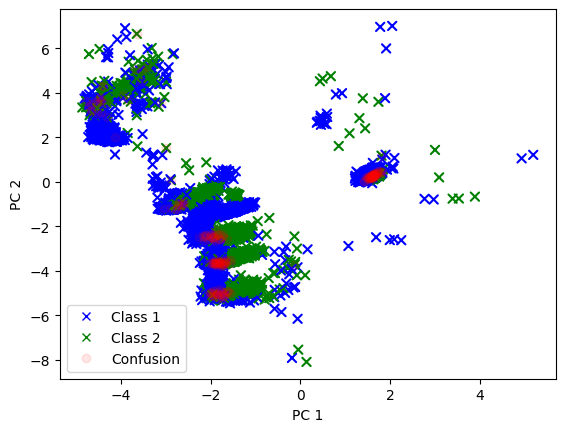

In [33]:
from matplotlib.lines import Line2D

plt.scatter(*pca.transform(either_class_X).T, color=either_class_color, marker='x')
plt.scatter(*pca.transform(confused_X).T, color='r', alpha=0.1)
plt.xlabel('PC 1')
plt.ylabel('PC 2')

custom = [Line2D([], [], marker='x', color='blue', linestyle='None'),
          Line2D([], [], marker='x', color='green', linestyle='None'),
          Line2D([], [], marker='o', color='red', linestyle='None', alpha=0.1)]

plt.legend(handles = custom, labels=['Class 1', 'Class 2', 'Confusion'], loc= "lower left")

Inspecting nearest neighbours

In [34]:
N_selection = 2500

selected_datapoints = datapoints[:N_selection]

In [35]:
distances = np.zeros((N_selection, N_selection))

for i in tqdm.tqdm(range(N_selection)):
    for j in range(N_selection):

        # Skipping symmetric
        if i > j:
            continue

        dist = np.linalg.norm(selected_datapoints[i][0]-selected_datapoints[j][0])

        distances[i,j] = dist
        distances[j,i] = dist

100%|██████████████████████████████████████| 2500/2500 [00:06<00:00, 416.07it/s]


In [36]:
np.fill_diagonal(distances, np.inf)
neighbours_by_nearness = np.argsort(distances, axis=0)

In [37]:
neighbours_by_nearness

array([[ 420,    5, 1254, ..., 1266, 2484,  793],
       [ 421, 1950, 1255, ...,  435, 2384,  761],
       [   4, 2335,  441, ..., 2483, 1238, 1655],
       ...,
       [ 756,  756,  756, ...,  756,  825,  417],
       [ 755,  755,  755, ...,  755,  755,  452],
       [   0,    1,    2, ..., 2497, 2498, 2499]])

In [38]:
len(selected_datapoints), np.mean([dp[1]==dp[2] for dp in selected_datapoints])

(2500, 0.8064)

In [46]:
datapoints_nearest_neighbour_same_class = [dp[1]==dp[2] for i, dp in enumerate(selected_datapoints) 
                                           if dp[1]!=selected_datapoints[neighbours_by_nearness[0,i]][1]]

In [47]:
len(datapoints_nearest_neighbour_same_class), 1-np.mean(datapoints_nearest_neighbour_same_class)

(717, 0.5313807531380753)

In [41]:
datapoints_2_nearest_neighbour_same_class = [dp[1]==dp[2] for i, dp in enumerate(selected_datapoints) 
                                             if (dp[1] == selected_datapoints[neighbours_by_nearness[0,i]][1] and 
                                                 dp[1] == selected_datapoints[neighbours_by_nearness[1,i]][1])]

In [ ]:
len(datapoints_2_nearest_neighbour_same_class), np.mean(datapoints_2_nearest_neighbour_same_class)

In [ ]:
datapoints_2_nearest_neighbour_same_class = [dp[1]==dp[2] for i, dp in enumerate(selected_datapoints) 
                                             if (dp[1] == selected_datapoints[neighbours_by_nearness[0,i]][1] and 
                                                 dp[1] == selected_datapoints[neighbours_by_nearness[1,i]][1] and 
                                                 dp[1] == selected_datapoints[neighbours_by_nearness[2,i]][1])]

In [ ]:
len(datapoints_2_nearest_neighbour_same_class), np.mean(datapoints_2_nearest_neighbour_same_class)

In [ ]:
datapoints_2_nearest_neighbour_same_class = [dp[1]==dp[2] for i, dp in enumerate(selected_datapoints) 
                                             if (dp[1] == selected_datapoints[neighbours_by_nearness[0,i]][1] and 
                                                 dp[1] == selected_datapoints[neighbours_by_nearness[1,i]][1] and 
                                                 dp[1] == selected_datapoints[neighbours_by_nearness[2,i]][1] and 
                                                 dp[1] == selected_datapoints[neighbours_by_nearness[3,i]][1])]

In [ ]:
len(datapoints_2_nearest_neighbour_same_class), np.mean(datapoints_2_nearest_neighbour_same_class)